In [1]:
# ## Load in Data
import pandas as pd
import pickle

path_to_files = "/D3/data/hweiner/Nexrad_Wrf_Amazon_Data/CoCoMET_out/merge_splits"

wrf_mergers = pd.read_csv(f"{path_to_files}/wrf_tobac_mergers.csv")
wrf_splitters = pd.read_csv(f"{path_to_files}/wrf_tobac_splitters.csv")

WRF_tracks = pd.read_csv(f"{path_to_files}/WRF_Tracks_tobac.csv")

with open(f'{path_to_files}/WRF_segmentation_2d_tobac.pickle', 'rb') as data:
    WRF_segmentation_2d = pickle.load(data)

wrf_splitters

,frame,split_cell,child_cells
0,[1 2],31,"(31, 3359)"
1,[1 2],33,"(33, 3333)"
2,[1 2],119,"(119, 3257)"
3,[1 2],340,"(340, 3190)"
4,[1 2],492,"(492, 3091)"
...,...,...,...
2021,[20 21],13994,"(13994, 15387)"
2022,[20 21],9138,"(9138, 15388)"
2023,[20 21],7979,"(7979, 15389)"
2024,[20 21],13988,"(13988, 15391)"


In [ ]:
from copy import deepcopy

# Find the mergers or splitters
split_or_merge = deepcopy(wrf_splitters) # wrf_mergers
mergers = False
splitters = not(mergers)

for i in split_or_merge.itertuples():
    index = i[0]

    frames = i[1].replace("[", "").replace("]", "").split(" ")
    frames = [int(f) for f in frames if f != ""]
    first_frame, last_frame = int(frames[0]), int(frames[1])

    if mergers:
        parents = i[2].replace("[", "").replace("]", "").split(" ")
        parents = [int(p) for p in parents if p != ""]
        first_parent, last_parent = int(parents[0]), int(parents[1])

        merged_cell = i[3]
    
        # Both cells must live longer than 5 frames
        lifetime = 5    
        if len(WRF_tracks[WRF_tracks["cell_id"] == first_parent]) > lifetime:
            if len(WRF_tracks[WRF_tracks["cell_id"] == last_parent]) > lifetime:
                print(split_or_merge.iloc[index])
    
    if splitters:
        parent = i[2]

        split_cells = i[3].replace("(", "").replace(")", "").split(", ")
        split_cells = [int(p) for p in split_cells if p != ""]
        first_split, last_split = int(split_cells[0]), int(split_cells[1])

        # Both cells must live longer than 5 frames
        lifetime = 5        
        if len(WRF_tracks[WRF_tracks["cell_id"] == first_split]) > lifetime:
            if len(WRF_tracks[WRF_tracks["cell_id"] == last_split]) > lifetime:
                print(split_or_merge.iloc[index])

In [3]:
from shapely import geometry
import rasterio.features
import geopandas as gpd
import numpy as np
import datetime
import matplotlib.ticker as mticker
import xarray as xr
import matplotlib.pyplot as plt

def get_gdf(
    segmentation : xr.Dataset, 
    t : int, 
    cell : int
) -> gpd.GeoDataFrame:
    """

    Inputs
    ------
        segmentation : xr.Dataset
            CoCoMET standard US_segmentation_2d dataset
        t : int
            The frame to retrieve cells from
        cell : int
            The cell to make into a geodataframe
    
    Returns
    -------
        my_gdf : gpd.GeoDataFrame
            A geodataframe of the specified cells at given frame. 
    """

    # Get only the requested cell segmentation
    cell_seg_full = segmentation.Cell_Segmentation[t].values
    cell_seg = -np.ones_like(cell_seg_full)
    cell_seg = np.where(cell_seg_full == cell, cell, cell_seg)
    
    # Return None if there is no segmentation
    if np.sum(cell_seg != -1) == 0:
        print(f'there are no cells at time {t}, returning None')
        return None

    # Get latitude and longitude arrays
    lat_arr = segmentation.latitude.values
    lon_arr = segmentation.longitude.values

    # Form polygons from numpy mask segmentation
    myShapes = rasterio.features.shapes(cell_seg, connectivity=8)
    x_y_coords_in_latlon = []
    values = []
    for shape in myShapes:
        x_y_coords_in_latlon.append(shape[0]["coordinates"][0])
        values.append(shape[1])

    polygons = []
    cell_list = []
    for ind, row in zip(values, x_y_coords_in_latlon):
        lat_list = []
        lon_list = []
        row_list = []
        skip = False
        for x, y in row:
            x_set = x - 1
            y_set = y - 1

            lat = lat_arr[int(y_set), int(x_set)]
            lon = lon_arr[int(y_set), int(x_set)]

            # If the cell is on the edge of the frame, remove it
            if ((x <= 0. and y <= 0.) or 
                x > lat_arr.shape[1] - 5 or y > lat_arr.shape[0] - 5
            ):
                skip = True
            else:
                lat_list.append(lat)
                lon_list.append(lon)

                latlon_coord = (lat, lon)

                row_list.append(latlon_coord)

        if not(skip):
            cell_list.append(ind)
            polygons.append(geometry.Polygon(list(zip(lon_list, lat_list))))
    
    crs = "EPSG:4326"

    cell_df = pd.DataFrame({"cell_id" : cell_list})
    my_gdf = gpd.GeoDataFrame(cell_df, crs=crs, geometry=polygons)
    return my_gdf


def plot_tracked_cells(
        segmentation : xr.Dataset,
        tracks : gpd.GeoDataFrame,
        merge_frames: list[int, int],
        cell: list[int, int],
        bounds: list[tuple, tuple] | None = None,
        save = None,
        **args,
):
    """
    Inputs
    ------
        segmentation : xr.Dataset
            CoCoMET standard US_segmentation_2d dataset
        tracks : gpd.GeoDataFrame
            CoCoMET standard US_tracks geodataframe
        merge_frames: list[int, int]
            A list of two frames across which the merge or split event occurs
        cell: list[int, int]
            A list of the two merging or splitting cells
        bounds: list[tuple, tuple] | None = None
            A list of two tuples containing the bounds for the plot in order [(lon_min, lon_max), (lat_min, lat_max))] or None. If None, the plot is automatically sized by the first cell. The default is None.
        save : str | None = None
            A string of the path to save figure to or None. If None, the figure will not be saved. The default is None.
        **args
            Throw away variables
    
    Returns
    -------
        gdf_to_plot : gpd.GeoDataFrame
            Geodataframe with the cell information across all frames
    """

    # Make figure
    plt.figure(figsize=[9, 9])
    ax = plt.subplot(111)

    # Plot country/state borders to make the plot look nice
    url = "/share/D3/data/hweiner/ne_10m_admin_1_states_provinces.zip"
    world = gpd.read_file(url)
    world.plot(ax=ax, edgecolor='black', facecolor='none')

    # Cut off the year, month, day of the datetimes
    if type(tracks["time"][0]) == str:
        lifetimes = np.unique(tracks["time"])
        full_datetime_lifetimes = [datetime.datetime.strptime(lt, "%Y-%m-%d %H:%M:%S") for lt in lifetimes]
        
    else:
        lifetimes = np.unique(tracks["time"]).astype('datetime64[s]').astype(str)
        full_datetime_lifetimes = [datetime.datetime.strptime(lt, "%Y-%m-%dT%H:%M:%S") for lt in lifetimes]

    datetime_lifetimes_str = [datetime.datetime.strftime(lt, "%H:%M:%S") for lt in full_datetime_lifetimes]
    datetime_lifetimes = [datetime.datetime.strptime(lt, "%H:%M:%S") for lt in datetime_lifetimes_str]

    minute_diff_from_init_lifetimes = [(n - datetime_lifetimes[0]).total_seconds() / 60 for n in datetime_lifetimes]

    # Lists of cell specific parameters
    cmap_list = ["Blues_r", "Reds_r"]
    pad_list = [-0.09, 0.09]

    # Iterate through both cells
    for cind, c in enumerate(cell):

        # if you want to cut the tail of a cell
        if f"t1_c{cind}_cut" in args:
            c_end = args[f"t1_c{cind}_cut"]
        else:
            c_end = 0

        # if you want to cut the head of a cell
        if f"t0_c{cind}_cut" in args:
            c_start = args[f"t0_c{cind}_cut"]
        else:
            c_start = 0
        
        t0 = np.min(tracks[tracks["cell_id"] == c]["frame"]) + c_start
        t1 = np.max(tracks[tracks["cell_id"] == c]["frame"]) - c_end
        alpha_index = np.linspace(1, 0.1, t1 - t0 + 1)

        # Start the geodataframe at the first time
        gdf_to_plot = get_gdf(segmentation=segmentation, t=t0, cell = c)
        gdf_to_plot["lifetime"] = datetime_lifetimes_str[t0]
        gdf_to_plot["minutes_from_init"] = minute_diff_from_init_lifetimes[t0]
        gdf_to_plot["alpha"] = alpha_index[0]

        # Go through each time step and concatenate the cell information with the geodataframe to plot
        for t_step, gdf_t in enumerate(np.arange(t0 + 1, t1 + 1, 1)):
            next_gdf = get_gdf(segmentation=segmentation, t=gdf_t, cell = c)
            if next_gdf is not None:
                next_gdf["lifetime"] = datetime_lifetimes_str[gdf_t]
                next_gdf["minutes_from_init"] = minute_diff_from_init_lifetimes[gdf_t]
                next_gdf["alpha"] = alpha_index[t_step+1]
                gdf_to_plot = pd.concat((gdf_to_plot, next_gdf))
            else:
                print(f'the gdf at time {gdf_t} is None')
                continue

        # variables to make plotting variables look nicer
        cell_lifetimes_for_legend = np.array(gdf_to_plot["lifetime"])
        cell_minute_diff_from_init = np.array(gdf_to_plot["minutes_from_init"])
        legend_tick_spacer = 1#int(np.floor((t1 - t0) / 2))

        # If it's the second cell, plot the merge/split line and use the color red
        gdf_to_plot.plot(ax=ax, edgecolor='black', alpha= gdf_to_plot["alpha"],
                column="minutes_from_init", legend=True, cmap=cmap_list[cind],#"Reds_r",
                legend_kwds={"format": mticker.FixedFormatter(cell_lifetimes_for_legend[::legend_tick_spacer]), 
                                "orientation": "horizontal", 
                                "shrink": 1,
                                "aspect": 80,
                                "pad": pad_list[cind],#0.09, 
                                "extend": "both", 
                                "ticks" : cell_minute_diff_from_init[::legend_tick_spacer]})

        # Plot the merge/split line and restrict the bounds on the plot if bounds are give
            # only needs to be done once so why not do it on the first cell
        if cind == 0:
            merge_lats  = []
            merge_lons = []

            tracks_cell_1 = tracks[tracks["cell_id"] == cell[-1]]
            tracks_cell_1_merge_frame = tracks_cell_1[tracks["frame"] == merge_frames[-1]]

            tracks_cell_2 = tracks[tracks["cell_id"] == cell[0]]
            tracks_cell_2_merge_frame = tracks_cell_2[tracks["frame"] == merge_frames[0]]

            merge_lats.append(tracks_cell_2_merge_frame["latitude"].values[0])
            merge_lats.append(tracks_cell_1_merge_frame["latitude"].values[0])

            merge_lons.append(tracks_cell_2_merge_frame["longitude"].values[0])
            merge_lons.append(tracks_cell_1_merge_frame["longitude"].values[0])

            if "label" in args:
                l = args["label"]
            else:
                l = "merge event"
            plt.plot(merge_lons, merge_lats, linestyle = '--', color='xkcd:electric green', alpha=0.7, label=l)

            if bounds is None:
            # derive the minimum and maximum plot bounds
                minx = np.min(gdf_to_plot['geometry'].bounds['minx'])
                miny = np.min(gdf_to_plot['geometry'].bounds['miny'])
                maxx = np.max(gdf_to_plot['geometry'].bounds['maxx'])
                maxy = np.max(gdf_to_plot['geometry'].bounds['maxy'])

                ax.set_xlim(minx * 1.001, maxx * 0.999)
                ax.set_ylim(miny * 1.001, maxy * 0.999)
            
            else:
                ax.set_xlim(*bounds[0])
                ax.set_ylim(*bounds[1])

            # append degrees to the x and y labels
            xtl = ax.get_xticklabels()
            ytl = ax.get_yticklabels()
            new_xtl = []
            new_ytl = []
            for ctl_x, ctl_y in zip(xtl, ytl):

                tx = ctl_x.get_text()
                try: # mpl uses weird negative signs, so just use a try/except
                    float(tx) < 0 # positive is east, negative is west
                    new_xtl.append(fr'{tx}$\degree$E')
                except:
                    new_xtl.append(fr'{tx[1:]}$\degree$W')

                ty = ctl_y.get_text()
                try:
                    float(ty) < 0 # positive is north, negative is south
                    new_ytl.append(fr'{ty}$\degree$N')
                except:
                    new_ytl.append(fr'{ty[1:]}$\degree$S')

            # Write x and y labels
            ax.set_xticklabels(new_xtl, rotation=45, fontsize=10)
            ax.set_yticklabels(new_ytl, rotation=45, fontsize=10)
        
        # Plot the tracks for each cell
        cell_tracks = tracks[tracks["cell_id"] == c]
        for ti in [0, 1]:
            if f"t{ti}_c{cind}_cut" in args:
                if ti == 1:
                    cell_tracks = cell_tracks[:-args[f"t1_c{cind}_cut"]]
                elif ti == 0:
                    cell_tracks = cell_tracks[args[f"t0_c{cind}_cut"]:]

        lats = cell_tracks['latitude'].values
        lons = cell_tracks['longitude'].values
        total_frames = len(cell_tracks["frame"])

        if cind == 1:
            colors_in_frame = plt.cm.Reds_r(np.linspace(0,1,total_frames))
        else:
            colors_in_frame = plt.cm.Blues_r(np.linspace(0,1,total_frames))


        for f in range(total_frames):
            plt.scatter(lons[f], lats[f], marker='o', color = colors_in_frame[f])

        else:
            plt.plot(lons, lats, linestyle='--', alpha = 0.6, color = "red" if cind == 1 else "blue")

    plt.legend(loc='upper left')
    plt.grid(alpha=0.4)
    plt.tight_layout()

    if save != None:
        plt.savefig(save, dpi=600)

    plt.show()
    return gdf_to_plot

/tmp/ipykernel_2263608/4166230912.py:212: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tracks_cell_1_merge_frame = tracks_cell_1[tracks["frame"] == merge_frames[-1]]
/tmp/ipykernel_2263608/4166230912.py:215: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tracks_cell_2_merge_frame = tracks_cell_2[tracks["frame"] == merge_frames[0]]
/tmp/ipykernel_2263608/4166230912.py:265: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xtl, rotation=45, fontsize=10)
/tmp/ipykernel_2263608/4166230912.py:266: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_ytl, rotation=45, fontsize=10)


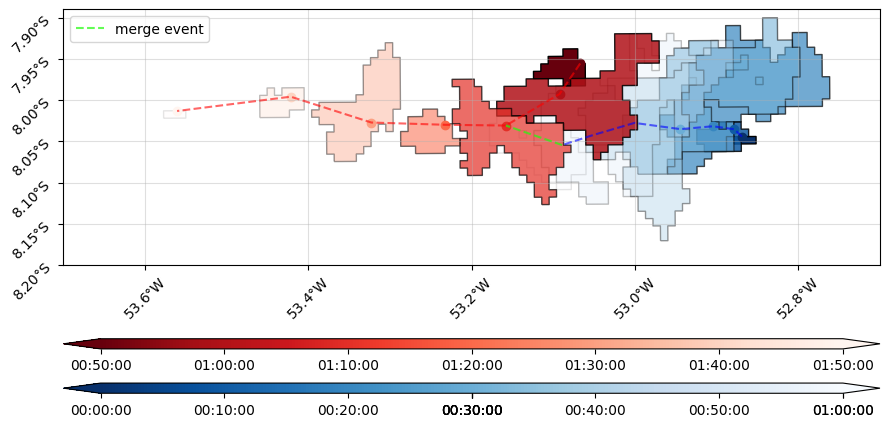

In [4]:
segmentation = WRF_segmentation_2d
tracks = WRF_tracks
bounds = [(-53.7, -52.7), (-8.2, -7.89)]
a = plot_tracked_cells(segmentation=segmentation, tracks=tracks, bounds = bounds,
                        # cell = [ 2032, 376], merge_frames = [4, 5])
                        # cell = [1678, 3973], merge_frames = [5, 6]) # bounds = [(-64.9, -64.55), (-9.76, -9.45)]
                        cell = [1822, 5214], merge_frames = [6, 7], t1_c1_cut = 1, save = None)#"/D3/data/hweiner/merge_example.png") # bounds = [(-53.7, -52.7), (-8.2, -7.89)]

/tmp/ipykernel_2263608/4166230912.py:212: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tracks_cell_1_merge_frame = tracks_cell_1[tracks["frame"] == merge_frames[-1]]
/tmp/ipykernel_2263608/4166230912.py:215: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tracks_cell_2_merge_frame = tracks_cell_2[tracks["frame"] == merge_frames[0]]
/tmp/ipykernel_2263608/4166230912.py:265: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xtl, rotation=45, fontsize=10)
/tmp/ipykernel_2263608/4166230912.py:266: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_ytl, rotation=45, fontsize=10)


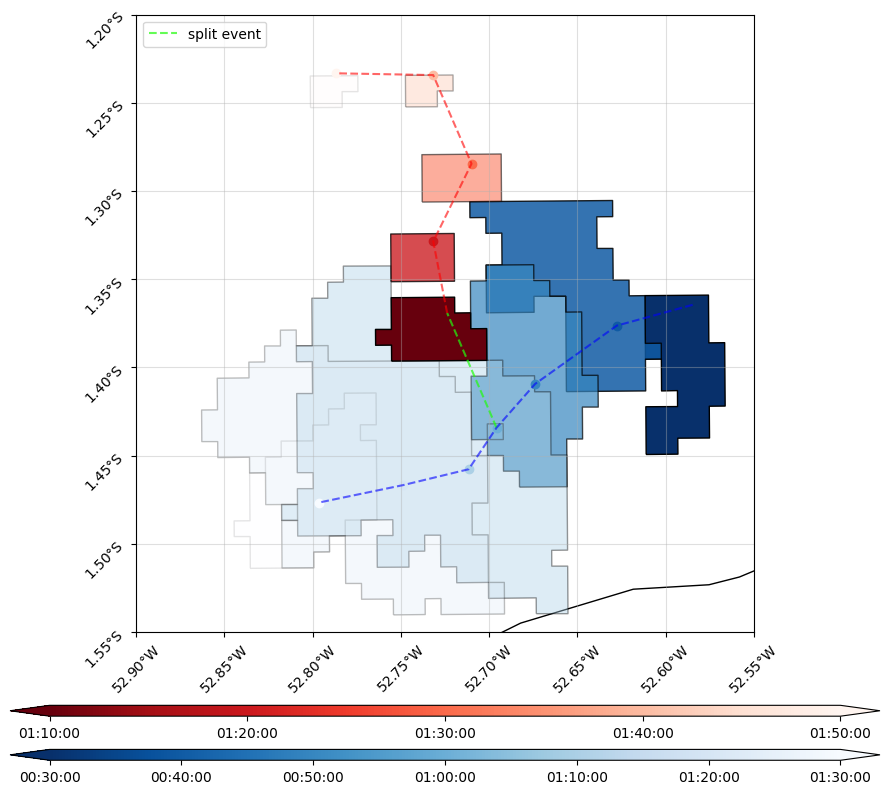

In [5]:
segmentation = WRF_segmentation_2d
tracks = WRF_tracks
bounds = [(-52.9, -52.55), (-1.55, -1.2)]
a = plot_tracked_cells(segmentation=segmentation, tracks=tracks, bounds = bounds,
                        # cell = [1113, 7070], merge_frames = [7, 8], label="split event") # bounds = [(-57.8, -57.27), (-11.9, -11.5)]
                        # cell = [2017, 7088], merge_frames = [7, 8], label="split event") # bounds = None
                        cell = [4016, 6464], merge_frames = [6, 7], label="split event", t1_c1_cut = 3, save=None)#"/D3/data/hweiner/split_example.png")
